In [485]:
import pandas as pd, numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [486]:
#traindf = pd.read_csv("D:/Group 1/Data/gtrain_df.csv", dtype={"fullVisitorId":"str"})
#testdf = pd.read_csv("D:/Group 1/Data/gtest_df.csv",dtype={"fullVisitorId":"str"})

In [487]:
train_df = traindf
test_df = testdf

In [488]:
#from sklearn.preprocessing import LabelEncoder

cat_cols = ["channelGrouping",
            "browser", 
           # "deviceCategory",
            "operatingSystem", 
            "city", 
           # "continent", 
           # "country",
            "metro",
            "networkDomain",
            "region", 
           # "subContinent", 
           # "adContent", 
           # "adwordsClickInfo.adNetworkType", 
            "adwordsClickInfo.gclId", 
           # "adwordsClickInfo.page", 
           # "adwordsClickInfo.slot",
           # "campaign",
           # "keyword", 
            "medium", 
            "referralPath", 
            "source",
           # "adwordsClickInfo.isVideoAd",
            "isTrueDirect"]


for col in cat_cols:
#    print(col)
    lbl = LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str'))) 
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))
    

In [489]:
num_cols = ["hits",
            "pageviews",
            "visitNumber",
            "visitStartTime",
           # "bounces",
            "newVisits"]    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)


In [490]:
#from sklearn.model_selection import train_test_split

y = np.log1p(train_df["transactionRevenue"].values)
X = train_df[cat_cols + num_cols + ['fullVisitorId']]

X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train = X_train_full[cat_cols + num_cols]

C:\Python\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until


In [491]:
params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "maxdepth" : 8,
        "min_child_samples" : 50,
        "learning_rate" : 0.03,
        "bagging_fraction" : 0.75,
        "feature_fraction" : 0.45,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1,
    }

In [492]:
lgtrain = lgb.Dataset(X_train, label=y_train)
lgval = lgb.Dataset(X_test_full[cat_cols + num_cols], label=y_test)
model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.58616
[200]	valid_0's rmse: 1.55795
[300]	valid_0's rmse: 1.54942
[400]	valid_0's rmse: 1.54446
[500]	valid_0's rmse: 1.54041
[600]	valid_0's rmse: 1.5375
[700]	valid_0's rmse: 1.5355
[800]	valid_0's rmse: 1.53446
[900]	valid_0's rmse: 1.53351
[1000]	valid_0's rmse: 1.5329
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 1.53289


In [493]:
#from sklearn import metrics

In [494]:
lgpred = model.predict(X_test_full[cat_cols + num_cols], num_iteration=model.best_iteration)

In [495]:
lgpred[lgpred < 0]=0

In [496]:
test_pred = pd.DataFrame({"fullVisitorId" : X_test_full["fullVisitorId"].values,
                          "transactionRevenue": np.expm1(lgpred), "y" : y_test})

In [497]:
test_pred_visitor = test_pred.groupby("fullVisitorId").agg({"transactionRevenue":"sum", "y":"sum"}).reset_index()

In [498]:
np.sqrt(metrics.mean_squared_error(np.log1p(test_pred_visitor["y"].values), 
                                         np.log1p(test_pred_visitor["transactionRevenue"].values)))

0.8893265892293785

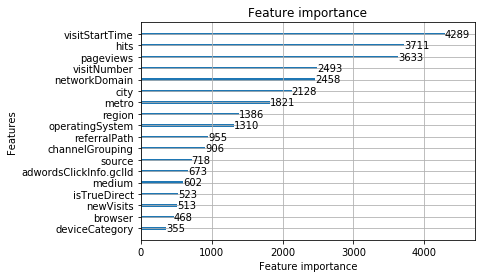

In [499]:
lgb.plot_importance(model)
plt.show()

In [500]:
pred = model.predict(test_df[cat_cols + num_cols], num_iteration=model.best_iteration)

In [501]:
pred[pred<0] = 0

In [502]:
pred_df_visit = pd.DataFrame({"fullVisitorId" : test_df["fullVisitorId"].values, "transactionRevenue": np.expm1(pred)})

In [503]:
pred_df_visitor = pred_df_visit.groupby('fullVisitorId').sum()['transactionRevenue'].reset_index()

In [504]:
pred_df_visitor['transactionRevenue'] = np.log1p(pred_df_visitor['transactionRevenue'])

In [505]:
test_df1 = test_df
test_df1.transactionRevenue = test_df1.transactionRevenue.fillna(0)

test1_grp = (test_df1.groupby('fullVisitorId').sum()['transactionRevenue'].reset_index())

In [506]:
df = pd.DataFrame({"pred":np.log1p(test1_grp.transactionRevenue.values),
                   "test":np.log1p(pred_df_visitor.transactionRevenue.fillna(0).values)})

In [507]:
df = df.fillna(0)

In [508]:
np.sqrt(mean_squared_error(df.pred, df.test))

1.948455712431258

In [509]:
#ss = pd.read_csv("D:/Group 1/Data/sample_submission_v2.csv")

In [510]:
final_sub = pd.merge(ss,pred_df_visitor , "left", on = 'fullVisitorId')

In [511]:
final_sub.transactionRevenue = final_sub.transactionRevenue.fillna(0)

In [512]:
final_subm = pd.DataFrame({"fullVisitorId": final_sub['fullVisitorId'],
                           "PredictedLogRevenue" : final_sub['transactionRevenue']})

In [513]:
#final_subm.to_csv('D:/Group 1/Data/final_subm1.csv', index = False)